# Interface Coupling

Let us start with grid creation. We use a .msh file that contains an interface $\Gamma = [0.25, 0.75] \times {0.5}$ as lower-dimensional physical entity embedded in a domain $\Omega = [0,1]^n$.

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh

dim = 2
file = "grids/horizontal.msh"

gridView  = mmesh((reader.gmsh, file), dim)
igridView = gridView.hierarchicalGrid.interfaceGrid

## Solve a problem on the bulk grid

Let us solve a Poisson problem on the bulk grid.
\begin{align}
 - \Delta u = f & \qquad \text{in}\ \Omega
\end{align}
Weak form
\begin{align}
 \int_\Omega \nabla u \cdot \nabla \phi dx = \int_\Omega f \phi dx
\end{align}

Manufactured solution
\begin{align}
 u &= \sin(4 \pi x y) \\
 f &= -\operatorname{div}( \nabla u )
\end{align}

In [2]:
from dune.fem.space import lagrange
space = lagrange(gridView, order=3)
uh = space.interpolate(0, name="solution")

In [3]:
from ufl import *

u = TrialFunction(space)
v = TestFunction(space)

x = SpatialCoordinate(space)
exact = sin(x[0]*x[1]*4*pi)
            
a = inner(grad(u), grad(v)) * dx
b = -div(grad(exact)) * v * dx

In [4]:
from dune.ufl import DirichletBC
from dune.fem.scheme import galerkin

scheme = galerkin([a == b, DirichletBC(space, exact)])
res = scheme.solve(target=uh)

0.00037301451643500404


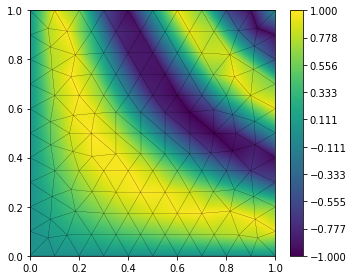

In [5]:
from dune.fem.function import integrate

def L2(u1, u2):
    return sqrt(integrate(u1.grid, (u1-u2)**2, order=5))

print(L2(uh, exact))

from dune.fem.plotting import plotPointData as plot
plot(uh)

## Solve a problem on the interface

We solve can solve similar problem on the interface $\Gamma$.

3.612197082257429e-05


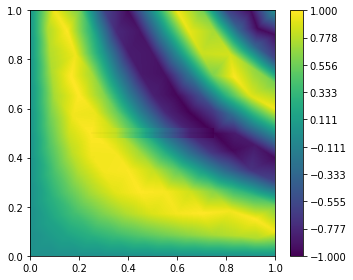

In [6]:
ispace = lagrange(igridView, order=3)
iuh = ispace.interpolate(0, name="isolution")

iu = TrialFunction(ispace)
iv = TestFunction(ispace)

ix = SpatialCoordinate(ispace)
iexact = sin(0.5*ix[dim-2]*4*pi)
    
ia = inner(grad(iu), grad(iv)) * dx
ib = -div(grad(iexact)) * iv * dx

ischeme = galerkin([ia == ib, DirichletBC(ispace, iexact)])
ischeme.solve(target=iuh)

print(L2(iuh, iexact))

import matplotlib.pyplot as plt
figure = plt.figure()

plot(uh, figure=figure, gridLines=None)
plot(iuh, figure=figure, linewidth=0.04, colorbar=None)

## Couple bulk to surface

We are able to compute traces of discrete functions on $\Omega$ along $\Gamma$.

In [7]:
from dune.mmesh import trace

tr = avg(trace(uh))

ib = inner(grad(tr), grad(iv)) * dx

iuh.interpolate(0)
ischeme = galerkin([ia == ib, DirichletBC(ispace, avg(trace(uh)))])
ischeme.solve(target=iuh)

print(L2(iuh, iexact))

3.8407947586460694e-05


## Couple surface to bulk

Similarly, we can evaluate a discrete function on $\Gamma$ at the skeleton of the triangulation of $\Omega$.

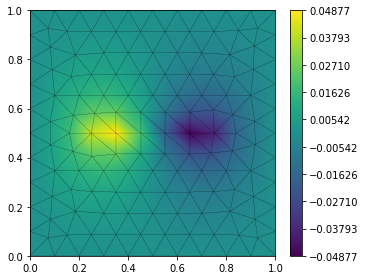

In [8]:
from dune.mmesh import skeleton

sk = skeleton(iuh)

b = avg(sk) * avg(v) * dS

uh.interpolate(0)
scheme = galerkin([a == b, DirichletBC(space, 0)])
scheme.solve(target=uh)

plot(uh)

## Compute jump of gradient of traces

We can use trace and skeleton within UFL expressions. This is useful when using jump and average operators, but also to compute gradients and more.

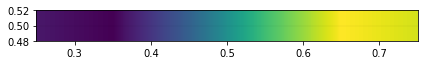

In [9]:
from dune.mmesh import normals

n = normals(igridView)
jmp = ispace.interpolate( jump(grad(trace(uh)), n), name="jumpGradTrace")

plot(jmp, linewidth=0.04, colorbar=None)